# Environment setup
The following code can help you install the packages required for the pyspark environment in Colab

In [ ]:
!pip install pyspark
!pip install nose

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 4.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488493 sha256=27d96ddba155437d640413442e9b5b626cb8146b5d4a6b020a0bc92838efd728
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.7/154.7 kB 2.9 MB/s eta 0:00:00


The following is to mount Google drive files

In [ ]:
# View and modify the working path
import os
from google.colab import drive

# View current working directory
print("Current Working Directory:", os.getcwd())

# Mount Google Drive
drive.mount('/content/gdrive')

# Change working directory to your file position
path = "/content/gdrive/My Drive/hw3_publish/code/data/"
os.chdir(path)

# Confirm the change
print("Working Directory:", os.getcwd())


Current Working Directory: /content
Mounted at /content/gdrive
Working Directory: /content/gdrive/My Drive/hw3_publish/code/data


# Models

In [ ]:
import pandas as pd
class Medication:
    "medication class"
    def __init__(self, patientID, date, medicine):
        self.patientID = patientID
        self.date = date
        self.medicine = medicine

class LabResult:
    "lab class"
    def __init__(self, patientID, date, resultName, value):
        self.patientID = patientID
        self.date = date
        self.resultName = resultName
        self.value = value

class Diagnostic():
    "diagnostic class"
    def __init__(self, patientID, code, date):
        self.patientID = patientID
        self.date = date
        self.code = code

def create_initial_score_df():
    # Test names
    test_names = ['RDDTest', 'PhenotypeTest', 'FeatureConstructionTest','TestGetPurity','ClusteringTest']
    # Initial scores set to 0
    initial_scores = [0, 0, 0, 0, 0]

    # Creating the DataFrame
    df = pd.DataFrame({'Test': test_names, 'Score': initial_scores})
    return df

# Create the initial DataFrame
df_score = create_initial_score_df()
df_score

,Test,Score
0,RDDTest,0
1,PhenotypeTest,0
2,FeatureConstructionTest,0
3,TestGetPurity,0
4,ClusteringTest,0


# Load RDD raw data 

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from datetime import datetime
from pyspark.sql.types import StringType, BooleanType, IntegerType, DoubleType
import sys
# sys.path.append('main/')
# from src.main.models import Diagnostic, Medication, LabResult

import logging
logging.getLogger('pyspark').setLevel(logging.ERROR)
logging.getLogger("py4j").setLevel(logging.ERROR)

# Change working directory base on your path
path = "/content/gdrive/My Drive/hw3_publish/code/data/"
os.chdir(path)


# Define the case classes
# this is in the model part in original files

# these are from main file
def sql_date_parser(input, pattern="yyyy-MM-dd'T'HH:mm:ssX"):
    date_format = datetime.strptime(input, pattern)
    return date_format.date()

def load_rdd_raw_data(spark):

    '''
    TODO:  load the input .csv files in the datafolder as structured RDDs
    param:
            spark : the SparkSession, it is used to configure Spark, create DataFrames, and execute SQL queries.
    return:
            rdd format for the medication, lab result and diagnostic
    task:
            1. Define the SQL queries and convert the resulting DataFrames into RDDs.
            in the SQL:
                - lab result querying: The query is selecting four columns: Member_ID, Date_Resulted, Result_Name, and Numeric_Result from lab_results_INPUT
                                     with a condition that Numeric_Result is not null and not an empty string.
                - diagnostic querying: The query is selecting three columns: Member_ID, Encounter_DateTime, and Code_ID from encounter_dx_INPUT joined
                                     with encounter_INPUT on the common column Encounter_ID.
                - medication querying: The query is selecting three columns: Member_ID, Order_Date, and Drug_Name from medication_orders_INPUT.
            2. The structure of the RDDs corresponds to the Medication, LabResult, and Diagnostic classes, this should be the same format as the model/model.py.
               - The Medication RDD has fields: patientID, date, and medicine.
               - The LabResult RDD has fields: patientID, date, resultName, and value.
               - The Diagnostic RDD has fields: patientID, date and code.
    '''
    lab_query = """
        SELECT Member_ID as patientID, Date_Resulted as date, Result_Name as resultName,
        CAST(REPLACE(Numeric_Result, ',', '') AS FLOAT) as value
        FROM lab_results_INPUT
        WHERE Numeric_Result IS NOT NULL AND Numeric_Result != ''
    """

    diagnostic_query = """
        SELECT e.Member_ID as patientID, e.Encounter_DateTime as date, dx.Code_ID as code
        FROM encounter_dx_INPUT dx
        JOIN encounter_INPUT e
        ON dx.Encounter_ID = e.Encounter_ID
    """

    medication_query = """
        SELECT Member_ID as patientID, Order_Date as date, Drug_Name as medicine
        FROM medication_orders_INPUT
    """
    # you may modify the path base on yours
    relative_path = "/content/gdrive/My Drive/hw3_publish/code/data/"
    file_name = ["encounter_INPUT.csv",\
                "encounter_dx_INPUT.csv", \
                "lab_results_INPUT.csv", \
                 "medication_orders_INPUT.csv"]

    csv_files = [relative_path+x for x in file_name]

    for file in csv_files:
        df = spark.read.format("csv").option("header", "true").option("inferSchema", "true").load(file)
        table_name = file.split("/")[-1].split(".")[0]
        df.createOrReplaceTempView(table_name)
    # Converting DataFrame to RDDs
    medication_rdd = spark.sql(medication_query).rdd
    lab_result_rdd = spark.sql(lab_query).rdd
    diagnostic_rdd = spark.sql(diagnostic_query).rdd
    # start your code at here

    return medication_rdd, lab_result_rdd, diagnostic_rdd


if __name__ == '__main__':
    spark = SparkSession.builder.appName("myApp").getOrCreate()
    medication_rdd, lab_result_rdd, diagnostic_rdd = load_rdd_raw_data(spark)
    medication_rdd = spark.sparkContext.parallelize(medication_rdd.collect())
    print(medication_rdd.count())
    print(lab_result_rdd.count())
    print(diagnostic_rdd.count())
    print(type(medication_rdd))
    spark.stop()

31552
106894
112811
<class 'pyspark.rdd.RDD'>


# Phenotype(Domain Knowledge Given)

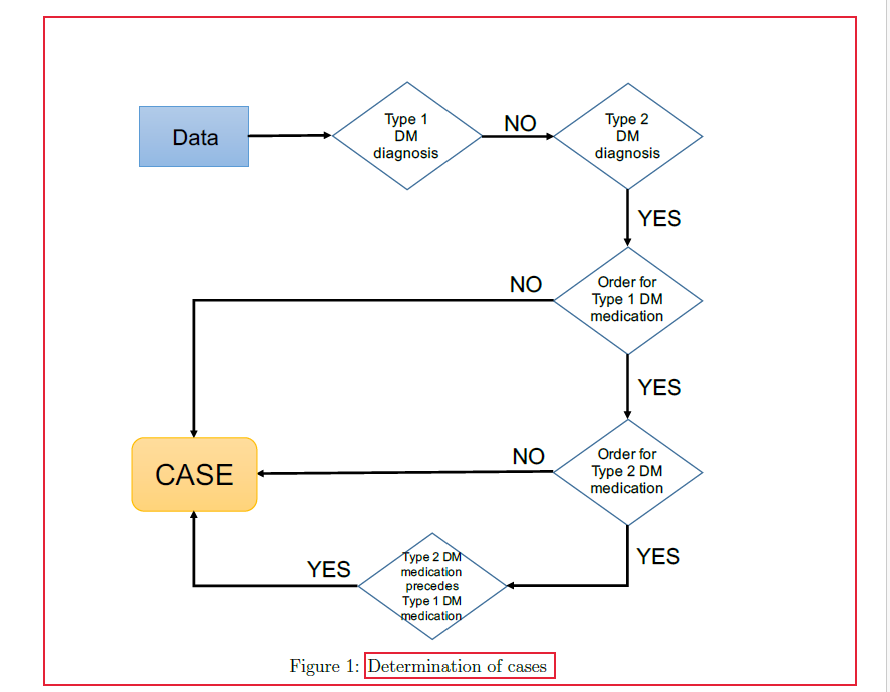

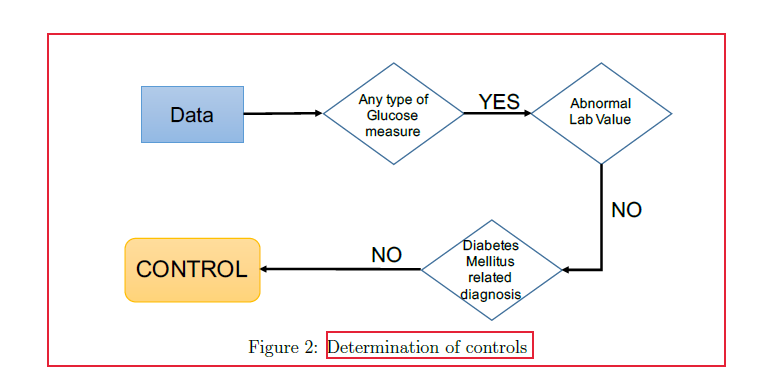

In [ ]:
#DEBUG IN GOOGLE COLAB
!pip install -Uqq ipdb
import ipdb
%pdb on

Automatic pdb calling has been turned ON


In [ ]:
from pyspark import SparkContext
from pyspark.rdd import RDD
from pyspark.sql import SparkSession
from pyspark.sql.functions import lower, lit, when, col, udf
from pyspark.sql.functions import min as min_

from typing import Tuple

import sys
sys.path.append('./')
# from src.main.models import Diagnostic, Medication, LabResult
# from src.main.loadRddRawData import load_rdd_raw_data


#class T2dmPhenotype:
T1DM_DX = {"250.01", "250.03", "250.11", "250.13", "250.21", "250.23", "250.31", "250.33", "250.41", "250.43",
               "250.51", "250.53", "250.61", "250.63", "250.71", "250.73", "250.81", "250.83", "250.91", "250.93"}

T2DM_DX = {"250.3", "250.32", "250.2", "250.22", "250.9", "250.92", "250.8", "250.82", "250.7", "250.72", "250.6",
               "250.62", "250.5", "250.52", "250.4", "250.42", "250.00", "250.02"}

T1DM_MED = {"lantus", "insulin glargine", "insulin aspart", "insulin detemir", "insulin lente", "insulin nph", "insulin reg", "insulin,ultralente"}

T2DM_MED = {"chlorpropamide", "diabinese", "diabanase", "diabinase", "glipizide", "glucotrol", "glucotrol xl",
                "glucatrol ", "glyburide", "micronase", "glynase", "diabetamide", "diabeta", "glimepiride", "amaryl",
                "repaglinide", "prandin", "nateglinide", "metformin", "rosiglitazone", "pioglitazone", "acarbose",
                "miglitol", "sitagliptin", "exenatide", "tolazamide", "acetohexamide", "troglitazone", "tolbutamide",
                "avandia", "actos", "actos", "glipizide"}

DM_RELATED_DX = {"790.21", "790.22", "790.2", "790.29", "648.81", "648.82", "648.83", "648.84", "648", "648",
    "648.01", "648.02", "648.03", "648.04", "791.5", "277.7", "V77.1", "256.4"}

abnormal_lab_values = {
        "HbA1c": 6.0,
        "Hemoglobin A1c": 6.0,
        "Fasting Glucose": 110.0,
        "Fasting blood glucose": 110.0,
        "fasting plasma glucose": 110.0,
        "Glucose": 110.0,
        "glucose": 110.0,
        "Glucose, Serum": 110.0
    }


def transform(medication, labResult, diagnostic):
    """
    TODO: Transform given data set to a RDD of patients and corresponding phenotype
    param:
            medication: An RDD containing patient medication data.
            labResult: An RDD containing patient lab results.
            diagnostic: An RDD containing patient diagnostic data.
    return:
            phenotypeLabel: An RDD containing tuples. Each tuple contains a patient ID and a corresponding phenotype label.
                            the calss label value should be 1,2 and 3. 1 is the Case Patients, 2 is the  Control Patients, and 3 is the others

    hints:
            Use the provided hints as a roadmap to tackle each step of the transformation process systematically. Especially for the figure 1 and 2.
            Understand the criteria for labeling a patient with diabetes.
            There are some explains about the two roadmap
            Case Patients (from the first diagram):
                The flow starts with patients' diagnostic information.
                It filters out patients with specific diagnostic codes related to Type 1 Diabetes Mellitus (T1DM).
                The remaining patients are further filtered to identify those with diagnostic codes related to Type 2 Diabetes Mellitus (T2DM).
                The flow then uses medication information to filter out patients with T1DM medication orders.
                Among the remaining patients, those with T2DM medication orders are further categorized.
                There are additional steps related to medication order dates and other criteria to finalize the list of case patients.
            Control Patients (from the second diagram):
                The flow starts with lab result information related to glucose.
                It filters out patients based on specific abnormal lab values related to diabetes diagnosis.
                Among the remaining patients, those with specific diagnostic codes related to diabetes or related conditions are filtered out.
                The remaining patients are categorized as control patients.
            Other Patients:
                Patients who don't fall into the "case" or "control" categories based on the above criteria are categorized as other patients.
    """
    phenotypeLabel = None
    # start your code at here---------------------------------------------------------------------------------------------------------
    no_t1dm_dx = diagnostic.filter(lambda x: x[2] not in T1DM_DX)
    #no_t1dm_dx.collect()
    case_patients_pre = no_t1dm_dx.filter(lambda x: x[2] in T2DM_DX).map(lambda x: (x[0], x[1])).reduceByKey(lambda x, y: min(x, y))

    t1dm_md = medication.filter(lambda x: x[2].lower() in T1DM_MED) \
                            .map(lambda x: (x[0], x[1])) \
                            .reduceByKey(lambda x, y: min(x, y))

    t2dm_md = medication.filter(lambda x: x[2].lower() in T2DM_MED) \
                            .map(lambda x: (x[0], x[1])) \
                            .reduceByKey(lambda x, y: min(x, y))

    early_t2dm_md = t1dm_md.join(t2dm_md).filter(lambda x: x[1][1] < x[1][0])


    case_patient_1 = case_patients_pre.subtractByKey(t1dm_md).map(lambda x: (x[0],1)).distinct()
    case_patient_2 = case_patients_pre.join(t1dm_md).subtractByKey(t2dm_md).map(lambda x: (x[0], 1)).distinct()
    case_patient_3 = case_patients_pre.join(t1dm_md).join(t2dm_md).join(early_t2dm_md).map(lambda x: (x[0], 1)).distinct()
    case_patients = case_patient_1.union(case_patient_2).union(case_patient_3).distinct()

    glucose_measure = labResult.filter(lambda x: "glucose" in x[2].lower())
    abnormal_lab = labResult.filter(lambda x:x[2] in abnormal_lab_values.keys() and float(x[3]) >= abnormal_lab_values[x[2]])
    diabetes_related_dx = diagnostic.filter(lambda x: x[2] in DM_RELATED_DX or x[2].startswith("250"))

    control_patients = glucose_measure \
                                            .subtractByKey(abnormal_lab) \
                                            .subtractByKey(diabetes_related_dx) \
                                            .map(lambda x: (x[0], 2)).distinct()

    total_patients = diagnostic.map(lambda x: x[0]).union(labResult.map(lambda x: x[0])).union(medication.map(lambda x: x[0])).distinct()
    other_patients = total_patients.subtract(case_patients.map(lambda x: x[0])).subtract(control_patients.map(lambda x: x[0])).map(lambda x: (x, 3)).distinct()


    phenotypeLabel = case_patients.union(control_patients).union(other_patients)


    return phenotypeLabel


if __name__ == '__main__':
    spark = SparkSession.builder.appName("myApp").getOrCreate()
    medication_rdd, lab_result_rdd, diagnostic_rdd = load_rdd_raw_data(spark)
    data = lab_result_rdd.collect()
    phenotypeLabel = transform(medication_rdd, lab_result_rdd, diagnostic_rdd)
    #ipdb.set_trace(context=6)
    print(phenotypeLabel.count())
    #view phenotypeLabel
    print(phenotypeLabel.take(5))
    print(phenotypeLabel.filter(lambda x: x[1] == 1).map(lambda x: x[0]).count())
    print(phenotypeLabel.filter(lambda x: x[1] == 2).map(lambda x: x[0]).count())
    print(phenotypeLabel.filter(lambda x: x[1] == 3).map(lambda x: x[0]).count())
    spark.stop()




3688
[('666000368-01', 1), ('666740861-01', 1), ('314009397-01', 1), ('666996528-01', 1), ('000386413-01', 1)]
976
948
1764


# Feature Engineering/Construction

In [ ]:
from pyspark.sql import SparkSession
from pyspark.ml.linalg import Vectors
from pyspark import RDD

from typing import Tuple
from typing import Set
from datetime import date

FeatureTuple = Tuple[Tuple[str, str], float]
#-------------classes

# #class FeatureTuple:
#   def __init__(self, patientID, code, count):
#     self.patientID = patientID
#     self.code = code
#     self.count = count
def constructDiagnosticFeatureTuple(diagnostic: RDD[Diagnostic], candidateCode: Set = None) -> RDD[FeatureTuple]:
    '''
    TODO: Aggregate feature tuples from diagnostic with COUNT aggregation,

    param:
            diagnostic: an RDD containing diagnostic data
            candidateCode: a set of ICD9 codes to filter by
    return:
            diag: an RDD containing feature tuples
    hint:
        the tuple's first element is the patient ID, and the second element is the ICD9 code. For each occurrence, assign a value of 1 and accumulate it
    '''
    diag = None
    # start your code at here------------------------------------------------



    # If candidateCode is not None, filter diagnostic RDD
    if candidateCode is not None:
      diagnostic = diagnostic.filter(lambda x: x.code in candidateCode)

      # Perform necessary transformations on the diagnostic RDD to create FeatureTuple
    diag_feature = diagnostic.map(lambda x: ((x.patientID, x.code), 1)) \
                            .reduceByKey(lambda x, y: x + y) \
                            .map(lambda x: ((x[0][0], x[0][1]), x[1]))

    return diag_feature

def constructMedicationFeatureTuple(medication: RDD[Medication], candidateMedication: Set = None) -> RDD[FeatureTuple]:
    '''
    TODO: Aggregate feature tuples from medication with COUNT aggregation,
    param:
            medication: an RDD containing medication data
            candidateMedication: a set of medication names to filter by
    return:
            med: a set of medication names to filter by
    hint:
            similar tot the former one
    '''
    med = None
    # start your code at here-------------------------------------------------


    # If candidateMedication is not None, filter medication RDD
    if candidateMedication is not None:
        medication = medication.filter(lambda x: x.medicine in candidateMedication)

    # Perform necessary transformations on the medication RDD to create FeatureTuple
    medications_feature = medication.map(lambda x: ((x.patientID, x.medicine), 1)) \
                             .reduceByKey(lambda x, y: x + y) \
                             .map(lambda x: ((x[0][0], x[0][1]), x[1]))



    return medications_feature

def constructLabFeatureTuple(labResult: RDD[LabResult], candidateLab: Set = None) -> RDD[FeatureTuple] :
    '''
    TODO: Aggregate feature tuples from lab result, using AVERAGE aggregation
    param:
            labResult: an RDD containing lab result data.
            candidateLab: a set of lab result names to filter by
    return:
            lab: an RDD containing feature tuples
    hint:
            unlike the previous two functions,
            this one requires you to track the number of times a lab test was conducted, the value of each test, and compute the average value
    '''
    lab = None
    # start your code at here-----------------------------

    # If candidateLab is not None, filter labResult RDD
    if candidateLab is not None:
        labResult = labResult.filter(lambda x: x.resultName in candidateLab)

    # Calculate the sum and count of lab results for each patient and test
    lab_sum_count = labResult.map(lambda x: ((x.patientID, x.resultName), (x.value, 1))) \
                             .reduceByKey(lambda x, y: (x[0] + y[0], x[1] + y[1]))

    # Calculate the average value for each patient and test
    lab_feature = lab_sum_count.map(lambda x: ((x[0][0], x[0][1]), x[1][0] / x[1][1]))

    return lab_feature


def construct(feature):
    '''
    TODO: Given a feature tuples RDD, construct features in vector
          format for each patient. feature name should be mapped
          to some index and convert to sparse feature format.
    param:
            feature: an RDD containing tuples where the inner tuple's first element is a combination of patient ID and feature name,
                      and the second element represents the feature's value.
    return:
            result: an RDD where each entry is a patient ID paired with a sparse vector representation of their features
    hint:
            the function should process the input data to represent it in a sparse vector format, grouping by patient ID.
            the sparse vector format is beneficial when dealing with high-dimensional data where many values can be zero,
            as it SAVES MEMORY by only storing non-zero values
    '''
    result = None
    # start your code at here----------------------

# Get SparkContext from SparkSession
    sc = SparkSession.builder.getOrCreate().sparkContext

    # Collect unique feature names and assign indices
    feature_names = feature.map(lambda x: x[0][1]).distinct().collect()
    feature_index = dict(zip(sorted(feature_names), range(len(feature_names))))

    # Broadcast feature index to all nodes
    sc_feature_map = sc.broadcast(feature_index)

    # Transform input feature tuples
    patient_and_features = feature.map(lambda x: (x[0][0], (sc_feature_map.value[x[0][1]], x[1]))).groupByKey()

    # Create sparse vectors for each patient
    result = patient_and_features.map(lambda x: (
        x[0],
        Vectors.sparse(len(sc_feature_map.value), [(feature_idx, value) for feature_idx, value in sorted(x[1])])
    ))


    return result



if __name__ == '__main__':
    spark = SparkSession.builder.appName('Construct Features').getOrCreate()

    sc = spark.sparkContext

    medication_rdd, lab_result_rdd, diagnostic_rdd = load_rdd_raw_data(spark)
    print(lab_result_rdd.count())
    diagnostic_feature_tuples = constructDiagnosticFeatureTuple(diagnostic_rdd)
    print(diagnostic_feature_tuples.count())
    print(diagnostic_feature_tuples.take(5))
    medicine_feature_tuples = constructMedicationFeatureTuple(medication_rdd)
    print(medicine_feature_tuples.count())
    print(medicine_feature_tuples.take(5))
    lab_result_feature_tuples  = constructLabFeatureTuple(lab_result_rdd)
    print(lab_result_feature_tuples.count())
    print(lab_result_feature_tuples.take(5))
    data = [Medication("patient1", date.today(), "code1"),
        Medication("patient1", date.today(), "code2")]
    meds = spark.sparkContext.parallelize(data)
    #add for construct-------------------------
    # Combine all feature tuples RDDs
    feature_rdd = diagnostic_feature_tuples.union(medicine_feature_tuples).union(lab_result_feature_tuples)
    #print(meds.collect())
    #print(meds.take(5))
    #feature_rdd = constructMedicationFeatureTuple(meds)
    #print(feature_rdd.collect())
    #print(feature_rdd.take(5))
    feature_sparse_vector = construct(feature_rdd)
    print(feature_sparse_vector.take(50))
    spark.stop()

106894
10157
[(('000140966-01', '250.00'), 15), (('818009099-01', '592.0'), 12), (('545360000-01', '584.9'), 16), (('666071437-01', '496'), 18), (('497910000-01', '584.9'), 17)]
12019
[(('000001950-01', 'OMS 50'), 1), (('297920000-01', 'Gentamicin'), 1), (('000137537-01', 'ACTIVASE'), 6), (('000638208-01', 'valsartan'), 2), (('512080000-01', 'Metoprolol'), 3)]
44262
[(('953005554-01', 'HbA1c'), 9.0), (('000040819-01', 'protein'), 10.0), (('514680000-01', 'glucose'), 80.0), (('000089036-01', 'BNP'), 200.0), (('000174134-01', 'creatinine'), 2.0)]
[('818009099-01', SparseVector(166, {0: 20.0, 11: 12.0, 40: 3.0, 54: 2.0, 63: 3.0, 72: 45.0, 74: 9.0, 85: 2.0, 90: 120.0, 98: 1.0, 112: -0.01, 113: -0.02, 118: 180.0, 119: 130.0, 137: 8.0, 143: 14.0, 145: 1.0, 148: 1.0, 159: 10.0})), ('545360000-01', SparseVector(166, {0: 18.0, 8: 16.0, 45: 65.0, 56: 3.9, 57: 3.0, 72: 45.0, 74: 9.0, 83: 2.0, 87: 4.0, 90: 120.0, 99: 43.0, 111: 43.0, 112: -0.01, 113: -0.02, 118: 180.0, 119: 130.0, 137: 8.0, 140: 8

In [ ]:
# Test clock

from pyspark.ml.linalg import Vectors

patient_features = spark.sparkContext.parallelize([
    (("patient1", "code0"), 42.0),
    (("patient1", "code2"), 24.0),
    (("patient2", "code1"), 12.0)
])

expected = ('patient1', Vectors.sparse(3, [(0, 24.0), (1, 49.0), (2, 19.0)]))

# Print the sparse vector directly
print(expected)


('patient1', SparseVector(3, {0: 24.0, 1: 49.0, 2: 19.0}))


# Clustering Purity Metric

In [ ]:
def getPurity(cluster_assignment_and_label):
    """
    TODO: base on the function to take the purity value
    param: cluster_assignment_and_label: rDD in the tuple format ((assigned_cluster_id, class), number)
    return: purity: the calculate purity value
    hints:
            Given input RDD with tuples of assigned cluster id by clustering,
            and corresponding real class. Calculate the getPurity of clustering.
            Purity is defined as
                        \fract{1}{N}\sum_K max_j |w_k \cap c_j|
            where N is the number of samples, K is the number of clusters, and j
            is the index of the class. w_k denotes the set of samples in the k-th cluster,
            and c_j denotes the set of samples of class j.
    """
    purity = None
    # start your code at here----------------------------------------------
    # Extract cluster assignments and labels from the input RDD
    clusters_labels = cluster_assignment_and_label.reduceByKey(lambda x, y: x + y)

    # Group by cluster assignment and class, then find the maximum count for each cluster
    max_counts = clusters_labels.groupBy(lambda x: x[0][0]).flatMap(lambda x: [max(x[1], key=lambda y: y[1])])

    # Sum up the maximum counts to get the total correct assignments
    total_correct = max_counts.map(lambda x: x[1]).sum()


    # Sum up the total occurrences for normalization
    total_occurrences = clusters_labels.map(lambda x: x[1]).sum()

    # Calculate purity
    purity = total_correct / total_occurrences


    return purity

# Clustering 


In [ ]:
from pyspark.sql import SparkSession, DataFrame
from pyspark.ml.feature import StandardScaler, PCA
from pyspark.ml.linalg import Vectors, DenseMatrix
from pyspark.ml.clustering import KMeans, GaussianMixture
from pyspark.sql.functions import udf
from pyspark.sql.types import IntegerType


def clustering(phenotypeLabel, rawFeatures, k=3):

    print('phenotypeLabel: ', phenotypeLabel.count())
    standardizer = StandardScaler(withMean=True, withStd=True)
    df_features = rawFeatures.toDF(["id", "features"])
    scaler_model = standardizer.setInputCol("features").setOutputCol("scaled_features").fit(df_features)
    df_features = scaler_model.transform(df_features)

    # Using DataFrame operations to extract raw feature vectors
    raw_feature_vectors = df_features.select('features').rdd.map(lambda x: x[0]).cache()
    print('raw_feature_vectors: ', raw_feature_vectors)

    # Reduce dimension
    pca = PCA(k=10, inputCol="scaled_features", outputCol="pca_features")
    pca_model = pca.fit(df_features)
    df_features = pca_model.transform(df_features)

    # Ensure phenotypeLabel is a DataFrame
    if not isinstance(phenotypeLabel, DataFrame):
        phenotypeLabel = phenotypeLabel.toDF(["id", "label"])

    kmeans_purity = gmm_purity = None
    '''
    TODO: 1. K Means Clustering using pyspark ml
    Train a k means model using the variabe featureVectors as input and set seed as 6250

    TODO: 2. GMM Clustering using spark ml
    Train a Gaussian Mixture model using the variabe featureVectors as input and set seed as 6250

    TODO: 3. Compare clustering for the k = 3 case with the ground truth phenotypes that you computed for the rule-based PheKB algorithms.
    You can edit all the code as you wish and to generate all the table 1 and table 2's data.

    parameters:
                phenotypeLabel: an RDD or DataFrame containing phenotype labels. Each entry has a unique ID and an associated label.
                rawFeatures: an RDD containing raw feature vectors. Each entry has a unique ID and a corresponding feature vector.
    returns:
                kmeans_purity: purity values corresponding to the clustering results of KMean
                gmm_purity: purity values corresponding to the clustering results of Gaussian Mixture Model (GMM)
    hints:
                implement clustering using KMeans and compute the purity of the resulting clusters.
                implement clustering using Gaussian Mixture Model (GMM) and compute the purity of the resulting clusters.
                return the purity values for KMeans and GMM.
    '''
    # start your code at here-------------------------------------------------------------------------
    # 1. K Means Clustering using pyspark ml
    kmeans = KMeans(k=k, seed=6250, featuresCol="pca_features")
    kmeans_model = kmeans.fit(df_features)
    kmeans_predictions = kmeans_model.transform(df_features)

    # 2. GMM Clustering using spark ml
    gmm = GaussianMixture().setK(k).setSeed(6250).setFeaturesCol("pca_features").setPredictionCol("prediction")
    gmm_model = gmm.fit(df_features)
    gmm_predictions = gmm_model.transform(df_features)

    kmeans_joined = kmeans_predictions.join(phenotypeLabel, "id").rdd.map(lambda row: ((row.prediction, row.label), 1)).reduceByKey(lambda a, b: a + b)
    gmm_joined = gmm_predictions.join(phenotypeLabel, "id").rdd.map(lambda row: ((row.prediction, row.label), 1)).reduceByKey(lambda a, b: a + b)

    kmeans_purity = getPurity(kmeans_joined)
    gmm_purity = getPurity(gmm_joined)
    #-----------------------------------------------
    # 1. Count the total data points in each cluster
    kmeans_cluster_counts = kmeans_joined.map(lambda x: (x[0][0], x[1])).reduceByKey(lambda a, b: a + b).collectAsMap()


    # 2. For each label, count the occurrences in each cluster
    label_counts_kmeans = kmeans_joined.map(lambda x: ((x[0][1], x[0][0]), x[1]))

   # 3. Calculate the percentage of each label in each cluster
    #kmeans_percentages = label_counts_kmeans.map(lambda x: ((x[0][0], x[0][1]), x[1] / kmeans_cluster_counts[x[0][1]]))
    # 3. Calculate the percentage of label 1 in each cluster
    label_1_counts_kmeans = label_counts_kmeans.filter(lambda x: x[0][0] == 1)
    # Calculate the sum of counts of label 1 across all clusters
    total_label_1_count = label_1_counts_kmeans.values().sum()
    # Calculate the percentage of label 1 in each cluster
    kmeans_percentages_label_1 = label_1_counts_kmeans.map(lambda x: (x[0][1], round(x[1] / total_label_1_count, 2)))

    # 4. Calculate the percentage of label 2 in each cluster
    label_2_counts_kmeans = label_counts_kmeans.filter(lambda x: x[0][0] == 2)
    # Calculate the sum of counts of label 2 across all clusters
    total_label_2_count = label_2_counts_kmeans.values().sum()
    # Calculate the percentage of label 2 in each cluster
    kmeans_percentages_label_2 = label_2_counts_kmeans.map(lambda x: (x[0][1], round(x[1] / total_label_2_count, 2)))


    # 5. Calculate the percentage of label 3 in each cluster
    label_3_counts_kmeans = label_counts_kmeans.filter(lambda x: x[0][0] == 3)
    # Calculate the sum of counts of label 3 across all clusters
    total_label_3_count = label_3_counts_kmeans.values().sum()
    # Calculate the percentage of label 3 in each cluster
    kmeans_percentages_label_3 = label_3_counts_kmeans.map(lambda x: (x[0][1], round(x[1] / total_label_3_count, 2)))
    return kmeans_purity, gmm_purity#, kmeans_joined.collect(), kmeans_cluster_counts, label_counts_kmeans.collect(),   kmeans_percentages_label_1.collect(), kmeans_percentages_label_2.collect(), kmeans_percentages_label_3.collect()

# Get percentages with test data

In [ ]:
if __name__ == "__main__":
    # Create a Spark session
    spark = SparkSession.builder.appName('Construct Features').getOrCreate()
    sc = spark.sparkContext

    # Load raw data
    #medication_rdd, lab_result_rdd, diagnostic_rdd = load_rdd_raw_data(spark)

    # Transform data
    # phenotypeLabel = transform(medication_rdd, lab_result_rdd, diagnostic_rdd)
    # diagnostic_feature_tuples = constructDiagnosticFeatureTuple(diagnostic_rdd)
    # medicine_feature_tuples = constructMedicationFeatureTuple(medication_rdd)
    # lab_result_feature_tuples = constructLabFeatureTuple(lab_result_rdd)
    # feature_rdd = diagnostic_feature_tuples.union(medicine_feature_tuples).union(lab_result_feature_tuples)
    # feature_sparse_vector = construct(feature_rdd)
    # Load the data output from the solution code
    phenotypeLabel = sc.textFile("phenotypeLabel.txt").map(lambda x: (x.split("\t")[0], int(x.split("\t")[1])))
    featureTuples = sc.textFile("featureTuples.txt").filter(lambda x: int(x[:9]) % 17 == 0).map(lambda x: ((x.split("\t")[0], x.split("\t")[1]), float(x.split("\t")[2])))
        # Convert tuples to vector using FeatureConstruction.construct solution
    rawFeatures = construct(featureTuples)
    # Cluster and get results
    kmeans_purity, gmm_purity, kmeans_joined, cluster_counts,label_counts,  kmean_percentages1,kmean_percentages2, kmean_percentages3  = clustering(phenotypeLabel, rawFeatures, k=3)

    # Print results
    print("KMeans Purity:", kmeans_purity)
    print("GMM Purity:", gmm_purity)
    # Print first 5 rows of kmeans_joined
    print("\nFirst 5 rows of kmeans_joined:")
    for row in kmeans_joined:
      print(row)
    # Print all rows of kmeans_joined

    print("step 1")
    for key, value in cluster_counts.items():
      print(key, value)
    print("step 2")
    for row in label_counts:
      print(row)
    print("label 1")
    for row in kmean_percentages1:
      print(row)
    print("label 2")
    for row in kmean_percentages2:
      print(row)
    print("label 3")
    for row in kmean_percentages3:
      print(row)
    # Stop Spark session
    spark.stop()

NameError: name 'SparkSession' is not defined

## Clustering Writting part [10 points]

### KNN Discussion
| Percentage Cluster | Case | Control | Unknown |
|--------------------|------|---------|---------|
| Cluster 1          | 70%   | 12%      | 47%      |
| Cluster 2          | 22%  | 38%     | 38%     |
| Cluster 3          | 8% | 50%    | 15%    |
| **Total**          | **100%** | **100%** | **100%** |



 We can see that the Case patients have more of a distinguishment to Cluster 1 however control and unknown patients are spread out and not distinguished well between clusters in KNN clustering algorithm which align well with a purity value in the range of 0.5+ seen for k=3. A higher distinguishment would be closer to 1 for all labels assigned to their respective cluster. Feature engineering from more up to date domain knoweldge, dimensionality reduction, or ensemble methods could help properly label these patients to case control and unknown better with a higher purity value closer to 1.

### GMM Discussion
| Percentage Cluster | Case | Control | Unknown |
|--------------------|------|---------|---------|
| Cluster 1          |12%   | 14%      | 37%      |
| Cluster 2          | 36%  | 12%     | 36%     |
| Cluster 3          | 52% | 74%    | 27%    |
| **Total**          | **100%** | **100%** | **100%** |



For GMM clustering with the same inputs it is seen that control patients are more distingished among all the cluster as opposed to case patients in KNN. Similarly the remaining labels are spread out and not distinguished well. Gaussian Mixture Model (GMM) inherently assumes that data points are generated from a mixture of several Gaussian distributions, allowing for more flexible cluster shapes. In contrast, K-Means assumes spherical clusters with equal variance and does not consider the underlying distribution of the data. Therefore, GMM may better capture complex and non-linear relationships in the data, leading to different cluster assignments, especially when the true underlying data distribution deviates from spherical clusters.

# Discussion on K-means and GMM Comparison
Base on the main function output the data you needed, you can modify the main function.


| k  | K-Means (All features) | K-Means (Filtered features) | GMM (All Features) | GMM (Filtered features) |
|----|------------------------|-----------------------------|--------------------|-------------------------|
| 2  |    0.54121                    |       0.65109                      |    0.48861                |         0.64798                |
| 5  |    0.53172                    |     0.87124                       |     0.55586               |      0.89443                   |
| 10 |    0.65537                    |    0.87297                         |       0.56264             |          0.89997               |
| 15 |       0.66052                 |         0.88474                    |         0.64073           |   0.89997
                         |




The higher purity values for filtered features compared to all features in K-Means (KNN) and Gaussian Mixture Models (GMM) suggest that the selected subset of features is more discriminative for clustering patients based on their labels. Filtering features may have removed noise or irrelevant information, allowing the clustering algorithms to focus on the more relevant aspects of the data, leading to improved cluster purity. A higher purity for increased k values seen here for both KNN and GMM with the visibly similar performance means that these patients may be further classified into more than 3 labels previously thought through the domain knowledge diagram. a higher k value may lead to more nuanced but potentially meaningful clusters, and it's always crucial to validate the results based on domain knowledge. It could indicate that the data has more nuanced patterns or substructures than what can be adequately captured by a simple three-cluster model. In other words, increasing the number of clusters might reveal more detailed distinctions in the data.

## Code for discussion on K-means and GMM

In [ ]:
''''
This is for you to run and get the outcome for the Discussion on K-means and GMM part,
you can modify this code as you want,
fill the result into the above's figure
'''
def loadLocalRawData() -> Tuple[Set[str], Set[str], Set[str]]:

    with open("/content/gdrive/My Drive/hw3_publish/code/data/med_filter.txt") as f:
        candidateMedication = set(map(str.lower, f.read().splitlines()))

    with open("/content/gdrive/My Drive/hw3_publish/code/data/lab_filter.txt") as f:
        candidateLab = set(map(str.lower, f.read().splitlines()))

    with open("/content/gdrive/My Drive/hw3_publish/code/data/icd9_filter.txt") as f:
        candidateDiagnostic = set(map(str.lower, f.read().splitlines()))

    return (candidateMedication, candidateLab, candidateDiagnostic)

def main():
    spark = SparkSession.builder.getOrCreate()
    sc = spark.sparkContext

    # Set log levels
    logger = spark._jvm.org.apache.log4j
    logger.Level.WARN

    # Initialize loading of data
    medication, lab_result, diagnostic = load_rdd_raw_data(spark)
    candidate_medication, candidate_lab, candidate_diagnostic = loadLocalRawData()

    # Conduct phenotyping
    phenotype_label = transform(medication, lab_result, diagnostic)


    # Feature construction with all features
    feature_tuples = constructDiagnosticFeatureTuple(diagnostic).union(
        constructLabFeatureTuple(lab_result)
    ).union(
        constructMedicationFeatureTuple(medication)
    )



    rawFeatures = construct(feature_tuples)

    kMeansPurity, gaussianMixturePurity = clustering(phenotype_label, rawFeatures)

    print(f"[All feature] purity of kMeans is: {kMeansPurity:.5f}")
    print(f"[All feature] purity of GMM is: {gaussianMixturePurity:.5f}")


    filteredFeatureTuples = constructDiagnosticFeatureTuple(diagnostic, candidate_diagnostic).union(
        constructLabFeatureTuple(lab_result, candidate_lab)
    ).union(
        constructMedicationFeatureTuple(medication, candidate_medication)
    )

    filteredRawFeatures = construct(filteredFeatureTuples)


    kMeansPurity2, gaussianMixturePurity2 = clustering(phenotype_label, filteredRawFeatures)

    print(f"[Filtered feature] purity of kMeans is: {kMeansPurity2:.5f}")
    print(f"[Filtered feature] purity of GMM is: {gaussianMixturePurity2:.5f}")
main()

phenotypeLabel:  3688
raw_feature_vectors:  PythonRDD[3665] at RDD at PythonRDD.scala:53
[All feature] purity of kMeans is: 0.66052
[All feature] purity of GMM is: 0.64073
phenotypeLabel:  3688
raw_feature_vectors:  PythonRDD[4076] at RDD at PythonRDD.scala:53
[Filtered feature] purity of kMeans is: 0.88474
[Filtered feature] purity of GMM is: 0.89997
